# Test of bespoke neural network

Import necessary modules:

In [1]:
from classes.MyModel import MyModel
import torch
import torch.nn as nn
import math as math
from pathlib import Path
from torchviz import make_dot
import time

from modules.helper_functions_tsp import (find_problem_size,
                                          find_distances_array,
                                          cost_fn_fact, 
                                          cost_fn_tensor, 
                                          hot_start, 
                                          hot_start_list_to_string
                                          )

from modules.helper_ML_functions import (find_device, 
                                         get_ready_to_train,
                                         train_model
                                         )

from modules.graph_functions import plot_sine_activation

from classes.MyDataLogger import MyDataLogger, MySubDataLogger

from modules.config import PRINT_FREQUENCY

Set up constants:

In [2]:
datalogger = MyDataLogger()
sdl = MySubDataLogger(runid = datalogger.runid)
sdl.update_general_constants_from_config()
sdl.update_ml_constants_from_config()
sdl.quantum = False
sdl.validate_input()

SubDataLogger instantiated.  Run ID = 20250411-10-52-09 - 10-52-09


Read in data, report on data read and validate distance array:

In [3]:
distance_array, sdl.best_dist = find_distances_array(sdl.locations, print_comments=True)

Reading distance data
Data will be read from filename networks\sim_dist_10_locs.txt.
It is known that the shortest distance is 290.2


Evaluate cost function and clear cache:

In [4]:
cost_fn = cost_fn_fact(sdl.locations, 
                       distance_array, 
                       sdl.gray, 
                       method = sdl.formulation, 
                       )
cost_fn.clear_cache()

Check if CUDA is available and set the device

In [5]:
device = find_device()
print(f"Using device: {device}")

Using device: cuda


Find problem size:

In [6]:
sdl.qubits = find_problem_size(sdl.locations, sdl.formulation)
print(f'There are {sdl.qubits} qubits needed for {sdl.locations} locations in the {sdl.formulation} formulation.')

There are 21 qubits needed for 10 locations in the original formulation.


Find a hot start using a lazy classical algorithm and find the quality of the hot start:

In [7]:
if sdl.hot_start:
    hot_start_list = hot_start(distance_array, sdl.locations)
    print(f'The hot start location list is {hot_start_list}')
    bin_hot_start_list = hot_start_list_to_string(hot_start_list, 
                                                sdl.locations, 
                                                sdl.gray, 
                                                sdl.formulation
                                                )
    print(f'This is equivalent to a binary list: {bin_hot_start_list}')
    bin_hot_start_list_tensor = torch.tensor([bin_hot_start_list])
    print(f'bin_hot_start_list_tensor = {bin_hot_start_list_tensor}')
    distance_tensor = cost_fn_tensor(bin_hot_start_list_tensor, cost_fn).clone().detach().requires_grad_(True)
    sdl.hot_start_dist = float(distance_tensor)
    print(f'The hot start distance is {sdl.hot_start_dist:.2f}, compared to a best distance of {sdl.best_dist:.2f}.')

The hot start location list is [0, 3, 5, 8, 9, 7, 2, 6, 1, 4]
This is equivalent to a binary list: [0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
bin_hot_start_list_tensor = tensor([[0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]])
The hot start distance is 312.30, compared to a best distance of 290.20.


Set up input as repeated hot start tensor calculated above:

In [8]:
if sdl.hot_start:
    unrepeated_input = bin_hot_start_list_tensor.float().to(device)
    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)
else:
    if sdl.mode == 8:
        #input is all zeros
        unrepeated_input = torch.full((1,sdl.qubits), 0).float().to(device)
    elif sdl.mode == 9:
        #input is 0.5
        unrepeated_input = torch.full((1,sdl.qubits), 0.5).float().to(device)

    my_input = unrepeated_input.repeat(sdl.shots, 1).requires_grad_(True)

In [9]:
unrepeated_input.size()

torch.Size([1, 21])

In [10]:
print(unrepeated_input.size())

torch.Size([1, 21])


Set up model with gradient required:

In [11]:

model = MyModel(sdl.qubits, 
                sdl.layers, 
                sdl.std_dev, 
                cost_fn,
                sdl.hot_start,
                ).to(device)
for param in model.parameters():
    param.requires_grad = True

Report on model parameters:

In [12]:
total_params = sum(
	param.numel() for param in model.parameters()
)
trainable_params = sum(
	p.numel() for p in model.parameters() if p.requires_grad
)

print(f'There are {total_params} parameters in total, of which {trainable_params} are trainable')

for name, param in model.named_parameters():
    print(f"Parameter {name} requires_grad: {param.requires_grad}")

There are 924 parameters in total, of which 924 are trainable
Parameter fc1.weight requires_grad: True
Parameter fc1.bias requires_grad: True
Parameter fc2.weight requires_grad: True
Parameter fc2.bias requires_grad: True


Test the Sine activation function and print out a graph:

Plot the sine activation function:

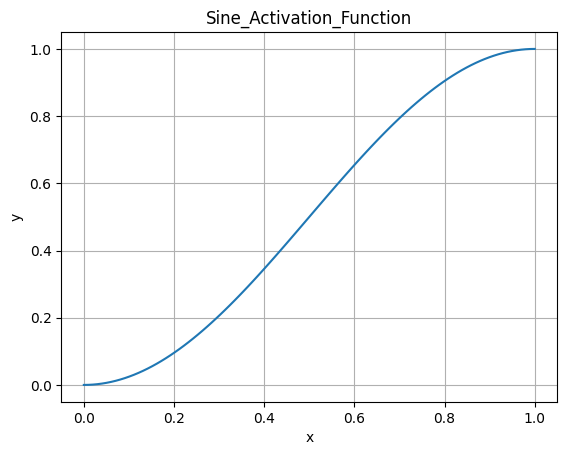

In [13]:
plot_sine_activation()

Print out model details including graph

{'fc1.weight': Parameter containing:
tensor([[ 1.1151e+00,  3.7955e-02,  3.9486e-02, -2.9778e-02, -7.6558e-02,
         -2.7645e-03,  4.1229e-02,  2.8317e-03, -4.9545e-02,  2.4165e-03,
          2.4726e-02, -3.0261e-03, -1.1270e-01,  1.8244e-02, -4.9981e-02,
          1.0174e-02, -3.2110e-02, -7.0124e-02, -3.4419e-02, -1.5067e-02,
         -7.4178e-02],
        [-9.4016e-02,  1.0115e+00, -2.8800e-02,  8.7733e-02,  6.0723e-02,
         -3.9088e-03,  5.4425e-02,  5.3707e-02,  2.5316e-02,  2.9147e-02,
          2.1547e-02,  2.7537e-02, -4.9721e-02,  2.9970e-02,  8.2528e-02,
         -8.6107e-02,  2.3042e-02, -5.3867e-03,  7.3045e-03,  1.5527e-02,
          7.2024e-02],
        [-6.7211e-03, -1.4848e-01,  9.2695e-01, -2.2952e-02,  2.7373e-03,
          5.0946e-02, -7.7550e-03,  1.4368e-02,  5.7131e-02,  5.5802e-02,
         -8.9818e-02, -3.7435e-02,  3.1624e-02, -9.1012e-03,  1.4510e-02,
         -5.8525e-02,  3.2439e-02,  5.5285e-02, -2.9388e-02,  5.9794e-02,
          8.7583e-02],
      

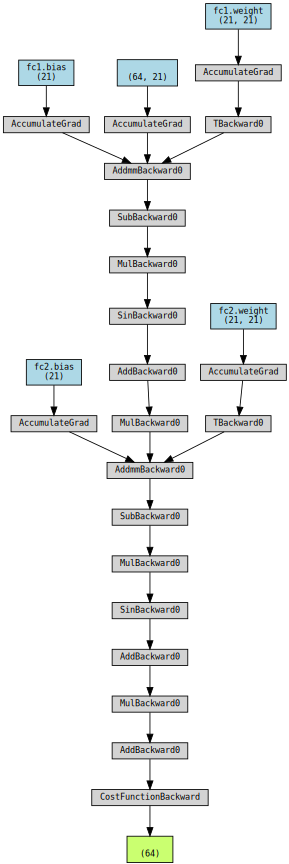

In [14]:
output = model(my_input)
lowest_cost = output.min()
filename = sdl.graph_sub_path.joinpath('torchviz')

param_dict = dict(model.named_parameters())
print(param_dict)  # Debugging: print the parameters to ensure they seem reasonable
make_dot(output, params=param_dict).render(filename, format="png")
make_dot(output, params=param_dict)

Set up criterion, optimizer and target ready to train model.

In [15]:
target, criterion, optimizer = get_ready_to_train(model, 
                                                  sdl.gradient_type, 
                                                  sdl.lr, 
                                                  sdl.weight_decay, 
                                                  momentum = sdl.momentum
                                                  )

Train model and print out results:

In [16]:

t0 = time.time()
sdl.best_dist_found, sdl.iteration_found, sdl.index_list, sdl.average_list, sdl.lowest_list =\
output_data = train_model(sdl.iterations,
                          model, 
                          my_input, 
                          target, 
                          criterion,
                          optimizer,
                          print_results=True,
                          print_frequency=PRINT_FREQUENCY
                          )

sdl.average_list_all.append(sdl.average_list)
sdl.lowest_list_all.append(sdl.lowest_list)
t1 = time.time()
elapsed = t1-t0
print(f'The time taken to run the code is {elapsed:.3f} seconds')
sdl.elapsed = elapsed
sdl.update_cache_statistics(cost_fn)
sdl.save_results_to_csv()
sdl.save_detailed_results()

Epoch 0, Average cost: 461.072 Epoch min cost:312.300, Lowest Cost to date: 312.300
Epoch 0, fc1.weight grad: 45277.71
Epoch 0, fc1.bias grad: 14318.07
Epoch 0, fc2.weight grad: 44618.86
Epoch 0, fc2.bias grad: 14556.74
Epoch 50, Average cost: 565.566 Epoch min cost:411.700, Lowest Cost to date: 312.300
Epoch 50, fc1.weight grad: 36877.33
Epoch 50, fc1.bias grad: 11661.63
Epoch 50, fc2.weight grad: 18040.19
Epoch 50, fc2.bias grad: 5644.15
Epoch 100, Average cost: 588.363 Epoch min cost:489.900, Lowest Cost to date: 312.300
Epoch 100, fc1.weight grad: 101871.96
Epoch 100, fc1.bias grad: 32214.74
Epoch 100, fc2.weight grad: 18537.21
Epoch 100, fc2.bias grad: 6317.81
Epoch 150, Average cost: 549.542 Epoch min cost:375.100, Lowest Cost to date: 312.300
Epoch 150, fc1.weight grad: 103572.43
Epoch 150, fc1.bias grad: 32752.48
Epoch 150, fc2.weight grad: 26906.58
Epoch 150, fc2.bias grad: 10291.39
Epoch 200, Average cost: 556.491 Epoch min cost:426.600, Lowest Cost to date: 312.300
Epoch 200

In [17]:
print(f'The lowest cost found was {sdl.best_dist_found:.3f} at epoch {sdl.iteration_found}.')
print(f'The best known cost is {sdl.best_dist:.3f}')
if sdl.hot_start:
    print(f'the hot start cost was {sdl.hot_start_dist:.3f}.')

The lowest cost found was 312.300 at epoch 0.
The best known cost is 290.200
the hot start cost was 312.300.


Plot loss ratio by epoch:

Graph for Run ID: 20250411-10-52-09-10-52-09 being saved to graphs\20250411-10-52-09\10-52-09.png


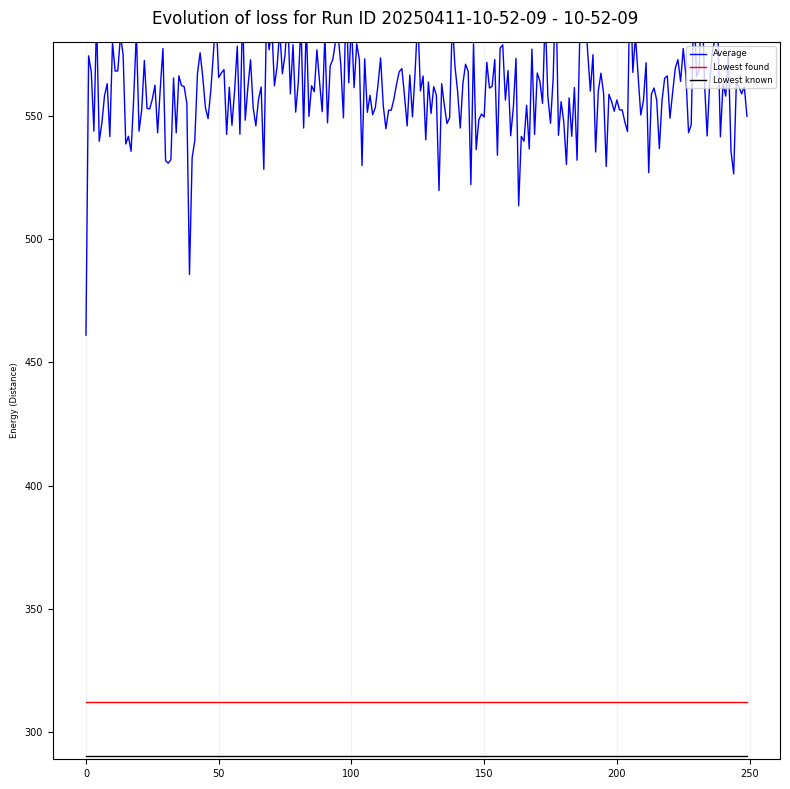

In [18]:
sdl.save_plot()


Print out parameters:

In [19]:
for layer in model.children():
    if isinstance(layer, nn.Linear):
        print('weight:', layer.weight)
        print('bias:', layer.bias)

weight: Parameter containing:
tensor([[ 1.1151e+00,  3.7954e-02, -1.2232e+01, -2.9777e-02, -7.6556e-02,
         -1.2274e+01, -1.2230e+01, -1.2268e+01, -4.9544e-02, -1.2269e+01,
         -1.2247e+01, -3.0261e-03, -1.2384e+01, -1.2253e+01, -4.9980e-02,
          1.0174e-02, -3.2109e-02, -1.2341e+01, -1.2306e+01, -1.5067e-02,
         -7.4177e-02],
        [-9.4014e-02,  1.0115e+00, -4.1473e+00,  8.7731e-02,  6.0722e-02,
         -4.1224e+00, -4.0640e+00, -4.0648e+00,  2.5316e-02, -4.0893e+00,
         -4.0969e+00,  2.7537e-02, -4.1682e+00, -4.0885e+00,  8.2526e-02,
         -8.6105e-02,  2.3042e-02, -4.1239e+00, -4.1112e+00,  1.5526e-02,
          7.2023e-02],
        [-6.7210e-03, -1.4848e-01, -1.9649e+01, -2.2951e-02,  2.7373e-03,
         -2.0525e+01, -2.0584e+01, -2.0561e+01,  5.7130e-02, -2.0520e+01,
         -2.0666e+01, -3.7434e-02, -2.0544e+01, -2.0585e+01,  1.4510e-02,
         -5.8524e-02,  3.2438e-02, -2.0521e+01, -2.0605e+01,  5.9793e-02,
          8.7581e-02],
        [-2.3